In [1]:
import numpy as np         
from sympy import *
import matplotlib.pyplot as plt
from matplotlib.pylab import *
from mpl_toolkits.axes_grid1 import *
import matplotlib.pylab as pylab
from mpl_toolkits.mplot3d import Axes3D
import h5py
import numpy.linalg as la
from matplotlib import rcParams
from scipy.stats import norm

def NumberConnections(Max,a,b):  
    Nc=[]
    Connections=[]

    for n in range(0,Max): 
        kx=np.where(a==n)[0]
        ky=np.where(b==n)[0]
        con=[]     
        for i in kx:
            con.append(b[i])
        for j in ky:
            con.append(a[j])
        Nc.append([n,len(kx)+len(ky)])
        Connections.append(con)
    
    Nc=np.array(Nc)
    return Nc.T[0],Nc.T[1],Connections

def DP(x1,y1,z1,x2,y2,z2):
    return np.sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)

def Eigen(A):
    w,v=la.eig(A)
    for i in range(len(w)):
        if w[i] < 0:
            w[i]=0
    return w

def Volume(a,b,c):
    v=a*b*c
    idv0=ID[v==0]
    v[idv0]=0.001
    return v

def AvD(D):
    k=0
    for j in D:
        k=k+j
    if len(D)==0:
        return 0
    else:
        return k/len(D)

def FA(a,b,c):
    fa=np.sqrt( ( (a-c)**2 +(c-b)**2 + (a-b)**2 )/( a**2 + b**2 + c**2  )   )
    idnan=ID[np.isnan(fa)]
    fa[idnan]=0
    print("fa=0 :"+str(len(idnan)))
    return idnan,fa

def Dist_Inert(Max,x,y,z):
    distance=[]
    eigv=[]
    for n in range(Max):
        distance_temp=[]
        Ixx=0
        Iyy=0
        Izz=0
        Ixy=0
        Iyz=0
        Ixz=0
        for i in con[n]:
            distance_temp.append(DP(x[n],y[n],z[n],x[i],y[i],z[i]))
            Ixx=Ixx+(y[i]-y[n])**2+(z[i]-z[n])**2
            Iyy=Iyy+(z[i]-z[n])**2+(x[i]-x[n])**2
            Izz=Izz+(x[i]-x[n])**2+(y[i]-y[n])**2
            Ixy=Ixy-(x[i]-x[n])*(y[i]-y[n])
            Iyz=Iyz-(y[i]-y[n])*(z[i]-z[n])
            Ixz=Ixz-(x[i]-x[n])*(z[i]-z[n])
        distance.append(AvD(distance_temp))
        
        A=np.array([[Ixx,Ixy,Ixz],[Ixy,Iyy,Iyz],[Ixz,Iyz,Izz]])
        eig=Eigen(A)
        eig=np.sort(eig)[::-1]# Major -> Minor
        eigv.append(eig)
#         print(eig)
        #print(str(n*100/(Max+1))+"%")
    return np.array(distance),np.array(eigv)

In [2]:
betafile="./data/beta_1.0_SDSS_data_Planck15.txt.BSKIndex"
a,b=loadtxt(str(betafile), unpack = True)
coorfile="./data/SDSS_data_Planck15.txt"
x,y,z=loadtxt(str(coorfile), unpack = True)

In [3]:
a=a.astype(int)
b=b.astype(int)
Max=len(x)
# print("len:"+str(Max))
ID,nc,con = NumberConnections(Max,a,b)
ad,eg=Dist_Inert(Max,x,y,z)

In [4]:
# To find halos with Zero connections
# for i in range(0,max(a)+1):
#     kk=np.where(a==i)[0]
#     ky=np.where(b==i)[0]
#     if len(kk)==0 and len(ky)==0:
#         print(i)

In [5]:
ID=np.array(ID).astype(int)
x=np.array(x)
y=np.array(y)
z=np.array(z)
nc=np.array(nc).astype(int)
con=np.array(con)
ad=np.array(ad)
a=np.sqrt(eg.T[0])
b=np.sqrt(eg.T[1])
c=np.sqrt(eg.T[2])
vol=Volume(a,b,c)
den=1/vol
idnan,fa=FA(a,b,c)

fa=0 :588


/home/asus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide
/home/asus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


In [6]:
f=h5py.File('Bsk_sdss.h5','w')
f.create_dataset('ID',data=ID)
f.create_dataset('coor',data=(x,y,z))
f.create_dataset('nc',data=nc)
# f.create_dataset('con',data=con) #Connections
f.create_dataset('av_d',data=ad)
f.create_dataset('eig',data=(a,b,c))
f.create_dataset('vol',data=vol)
f.create_dataset('den',data=den)
f.create_dataset('fa',data=fa)
f.close()

In [7]:
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
font = {'family' : 'serif',
        'size'   : 20}
mpl.rc('font', **font)

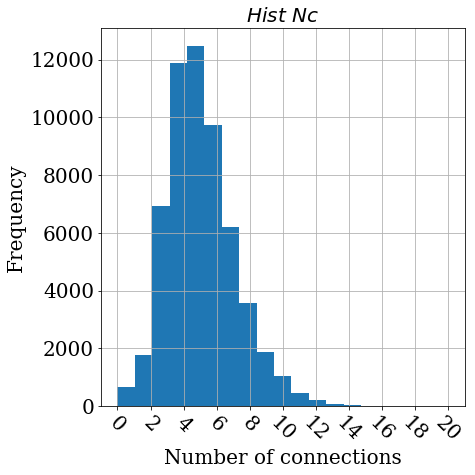

In [8]:
fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0, max(nc)+1, 2)
ax.set_xticks(major_ticks)
ax.grid(which='both')

plt.hist(nc,bins=max(nc)-1)
plt.title(r'$Hist\,\,Nc$',size=20)
plt.xlabel("Number of connections",size=20)
plt.ylabel("Frequency",size=20)
plt.xticks(rotation=-45)
plt.tight_layout()
plt.savefig("./Figures/nc_sdss.png")
plt.show()

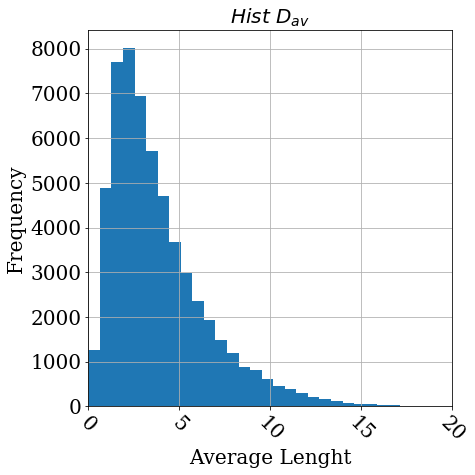

In [9]:
fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0, max(ad)+1, 5)
ax.set_xticks(major_ticks)
ax.grid(which='both')

plt.hist(ad,bins=np.linspace(0.0,max(ad),50))
plt.title(r'$Hist\,\,D_{av}$',size=20)
plt.xlabel("Average Lenght",size=20)
plt.ylabel("Frequency",size=20)
plt.xlim(0,20)
plt.xticks(rotation=-45)
plt.tight_layout()
plt.savefig("./Figures/ad_sdss.png")
plt.show()

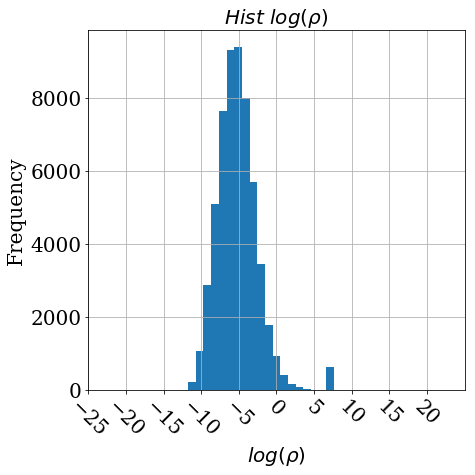

In [10]:
denlog=np.log(den)
fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(-25,25, 5)
ax.set_xticks(major_ticks)
ax.grid(which='both')

n, bins, patches=plt.hist(denlog,bins=np.linspace(-25,25,50))
plt.title(r'$Hist\,\,log(\rho)$',size=20)
plt.xlabel(r'$log(\rho)$',size=20)
plt.ylabel("Frequency",size=20)
plt.xticks(rotation=-45)
plt.tight_layout()
plt.xlim(-25,25)
plt.savefig("./Figures/density_sdss.png")
plt.show()

/home/asus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


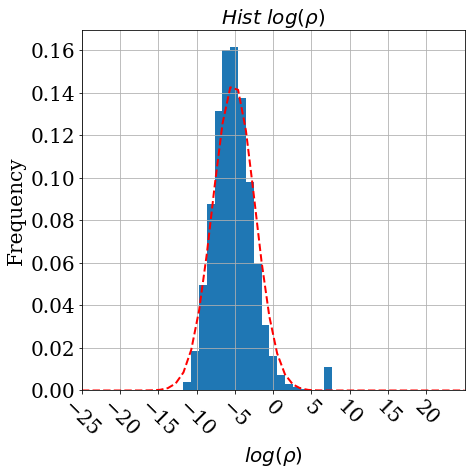

In [11]:
fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(-25,25, 5)
ax.set_xticks(major_ticks)
ax.grid(which='both')
(mu, sigma) = norm.fit(denlog)
denlog_fit = mlab.normpdf( bins, mu, sigma)
plt.hist(denlog,bins=np.linspace(-25,25,50),density=True)
plt.plot(bins, denlog_fit, 'r--', linewidth=2)
plt.title(r'$Hist\,\,log(\rho)$',size=20)
plt.xlabel(r'$log(\rho)$',size=20)
plt.ylabel("Frequency",size=20)
plt.xticks(rotation=-45)
plt.tight_layout()
plt.xlim(-25,25)
plt.savefig("./Figures/density_sdss_fit.png")
plt.show()

In [12]:
med_denlog=np.mean(denlog)

peak_ld= ( denlog > (med_denlog + sigma) )
filament_ld = ( denlog > med_denlog) & (denlog < (med_denlog+sigma) ) 
sheet_ld = ( denlog > (med_denlog-sigma)) & (denlog < med_denlog )
void_ld = ( denlog < (med_denlog-sigma ) )

In [13]:
idpeak=ID[peak_ld]
idfilament=ID[filament_ld]
idsheet=ID[sheet_ld]
idvoid=ID[void_ld]
env=np.zeros(len(x))+1000
env[idpeak]=0 #peaks=0
env[idfilament]=1 #filaments=1
env[idsheet]=2 #sheets=2
env[idvoid]=3 #voids=3

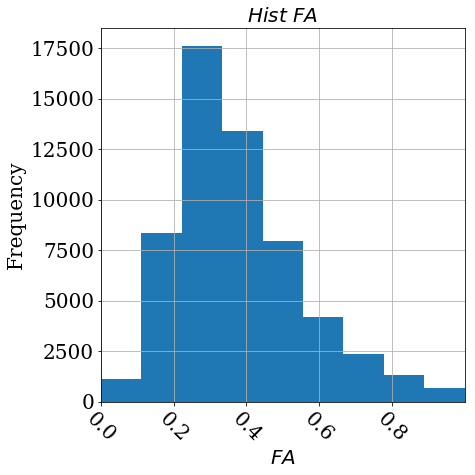

In [14]:
fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0,1,0.2)
ax.set_xticks(major_ticks)
ax.grid(which='both')

plt.hist(fa,bins=np.linspace(0,1,10))
plt.title(r'$Hist\,\,FA$',size=20)
plt.xlabel(r'$FA$',size=20)
plt.ylabel("Frequency",size=20)
plt.xticks(rotation=-45)
plt.tight_layout()
plt.xlim(0,1)
plt.savefig("./Figures/fa_sdss.png")
plt.show()

In [15]:
f=h5py.File('Bsk_sdss.h5','w')
f.create_dataset('ID',data=ID)
f.create_dataset('coor',data=(x,y,z))
f.create_dataset('nc',data=nc)
# f.create_dataset('con',data=con) #Connections
f.create_dataset('av_d',data=ad)
f.create_dataset('abc',data=(a,b,c))
f.create_dataset('vol',data=vol)
f.create_dataset('den',data=den)
f.create_dataset('fa',data=fa)
f.create_dataset('env',data=env)
f.close()

In [16]:
fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0, max(a), 5)
ax.set_xticks(major_ticks)
ax.grid(which='both')

print("Max:"+str(max(a)))
print("Min:"+str(min(a)))
print("Av:"+str(sum(a)/len(a)))

plt.hist(a,bins=np.linspace(0.0,max(a),50))
plt.xlim(0,50)
plt.title(r'$Hist\,\,a$',size=20)
plt.xlabel(r'$a$',size=20)
plt.ylabel("Frequency",size=20)
plt.xticks(rotation=-45)
plt.tight_layout()
plt.savefig("./Figures/a_sdss.png")
plt.show()

Max:80.79233846854575
Min:0.0
Av:9.667914889638789


Max:76.96392054310013
Min:0.0
Av:8.756361643109251


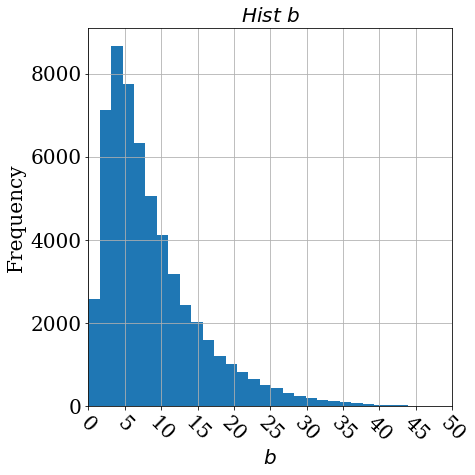

In [17]:
fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0, max(b), 5)
ax.set_xticks(major_ticks)
ax.grid(which='both')

print("Max:"+str(max(b)))
print("Min:"+str(min(b)))
print("Av:"+str(sum(b)/len(b)))

plt.hist(b,bins=np.linspace(0.0,max(b),50))
plt.title(r'$Hist\,\,b$',size=20)
plt.xlabel(r'$b$',size=20)
plt.ylabel("Frequency",size=20)
plt.xlim(0,50)
plt.xticks(rotation=-45)
plt.tight_layout()
plt.savefig("./Figures/b_sdss.png")
plt.show()

Max:62.97947661073801
Min:0.0
Av:5.7852281995885875


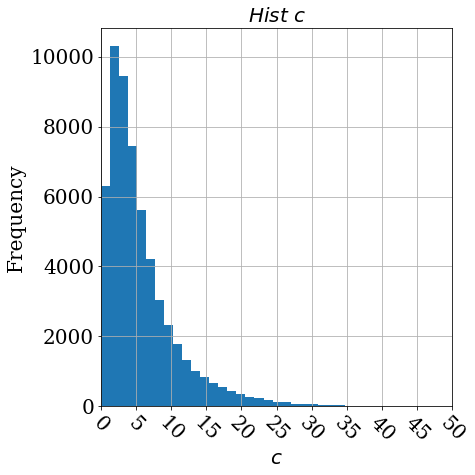

In [18]:
fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0, max(c), 5)
ax.set_xticks(major_ticks)
ax.grid(which='both')

print("Max:"+str(max(c)))
print("Min:"+str(min(c)))
print("Av:"+str(sum(c)/len(c)))

plt.hist(c,bins=np.linspace(0.0,max(c),50))
plt.title(r'$Hist\,\,c$',size=20)
plt.xlabel(r'$c$',size=20)
plt.ylabel("Frequency",size=20)
plt.xlim(0,50)
plt.xticks(rotation=-45)
plt.tight_layout()
plt.savefig("./Figures/c_sdss.png")
plt.show()

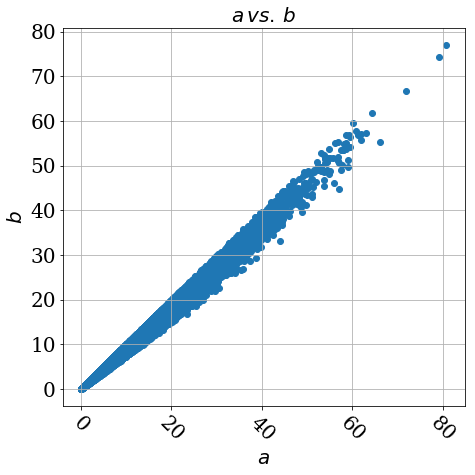

In [19]:
fig= plt.figure(figsize=(7,7))
plt.scatter(a,b)
plt.title(r'$a\,vs.\,b$',size=20)
plt.xlabel(r'$a$',size=20)
plt.ylabel(r'$b$',size=20)
plt.grid()
plt.xticks(rotation=-45)
plt.tight_layout()
# plt.savefig("./Figures/ls1_sdss.png")
plt.show()

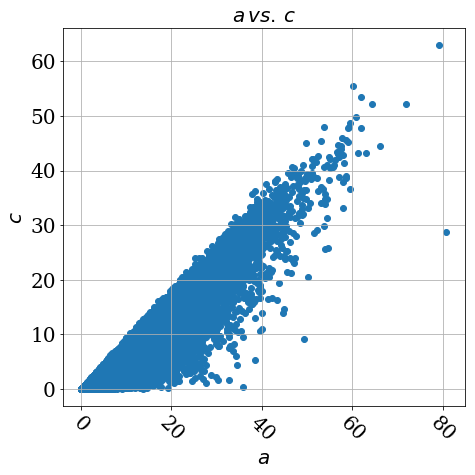

In [20]:
fig= plt.figure(figsize=(7,7))
plt.scatter(a,c)
plt.title(r'$a\,vs.\,c$',size=20)
plt.xlabel(r'$a$',size=20)
plt.ylabel(r'$c$',size=20)
plt.grid()
plt.xticks(rotation=-45)
plt.tight_layout()
# plt.savefig("./Figures/ls2_sdss.png")
plt.show()

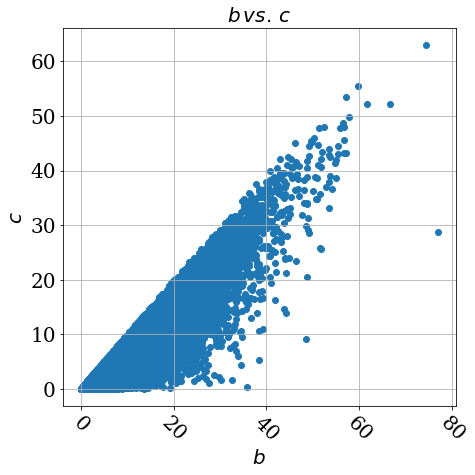

In [21]:
fig= plt.figure(figsize=(7,7))
plt.scatter(b,c)
plt.title(r'$b\,vs.\,c$',size=20)
plt.xlabel(r'$b$',size=20)
plt.ylabel(r'$c$',size=20)
plt.grid()
plt.xticks(rotation=-45)
plt.tight_layout()
# plt.savefig("./Figures/ls3_sdss.png")
plt.show()

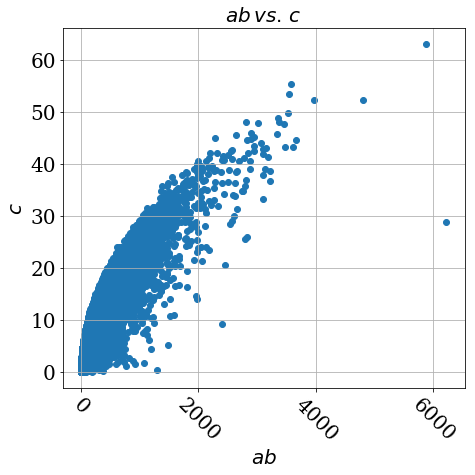

In [22]:
fig= plt.figure(figsize=(7,7))
plt.scatter(a*b,c)
plt.title(r'$ab\,vs.\,c$',size=20)
plt.xlabel(r'$ab$',size=20)
plt.ylabel(r'$c$',size=20)
plt.grid()
plt.xticks(rotation=-45)
plt.tight_layout()
# plt.savefig("./Figures/ls4_sdss.png")
plt.show()

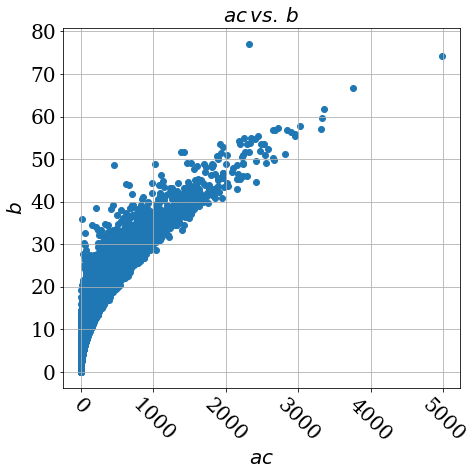

In [23]:
fig= plt.figure(figsize=(7,7))
plt.scatter(a*c,b)
plt.title(r'$ac\,vs.\,b$',size=20)
plt.xlabel(r'$ac$',size=20)
plt.ylabel(r'$b$',size=20)
plt.grid()
plt.xticks(rotation=-45)
plt.tight_layout()
# plt.savefig("./Figures/ls5_sdss.png")
plt.show()

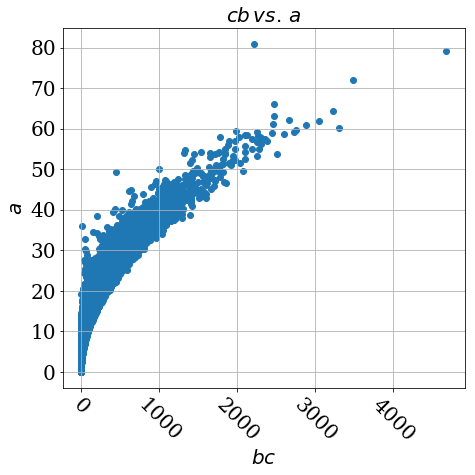

In [24]:
fig= plt.figure(figsize=(7,7))
plt.scatter(b*c,a)
plt.title(r'$cb\,vs.\,a$',size=20)
plt.xlabel(r'$bc$',size=20)
plt.ylabel(r'$a$',size=20)
plt.grid()
plt.xticks(rotation=-45)
plt.tight_layout()
# plt.savefig("./Figures/ls6_sdss.png")
plt.show()

/home/asus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/asus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


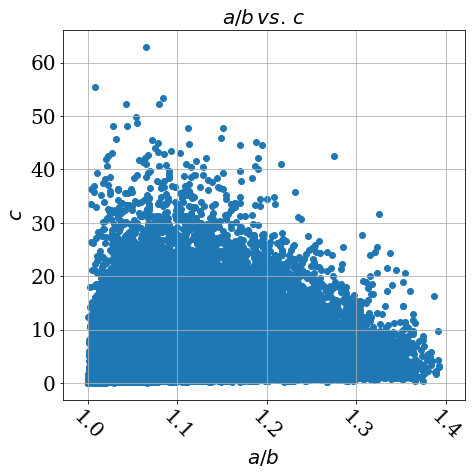

In [25]:
fig= plt.figure(figsize=(7,7))
plt.scatter(a/b,c)
plt.title(r'$a/b\,vs.\,c$',size=20)
plt.xlabel(r'$a/b$',size=20)
plt.ylabel(r'$c$',size=20)
plt.grid()
plt.xticks(rotation=-45)
plt.tight_layout()
# plt.savefig("./Figures/ls7_sdss.png")
plt.show()

/home/asus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/asus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


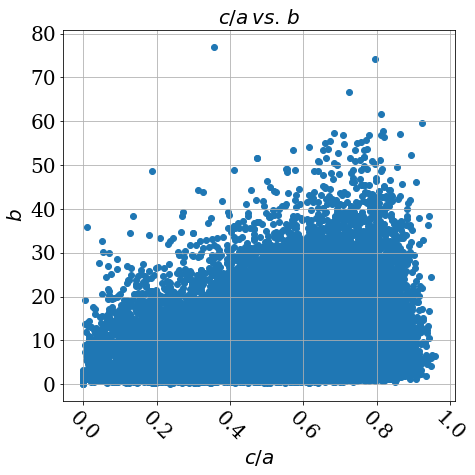

In [26]:
fig= plt.figure(figsize=(7,7))
plt.scatter(c/a,b)
plt.title(r'$c/a\,vs.\,b$',size=20)
plt.xlabel(r'$c/a$',size=20)
plt.ylabel(r'$b$',size=20)
plt.grid()
plt.xticks(rotation=-45)
plt.tight_layout()
# plt.savefig("./Figures/ls8_sdss.png")
plt.show()

/home/asus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/asus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


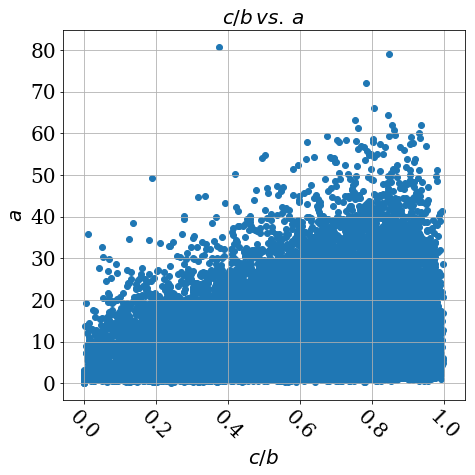

In [27]:
fig= plt.figure(figsize=(7,7))
plt.scatter(c/b,a)
plt.title(r'$c/b\,vs.\,a$',size=20)
plt.xlabel(r'$c/b$',size=20)
plt.ylabel(r'$a$',size=20)
plt.grid()
plt.xticks(rotation=-45)
plt.tight_layout()
# plt.savefig("./Figures/ls9_sdss.png")
plt.show()

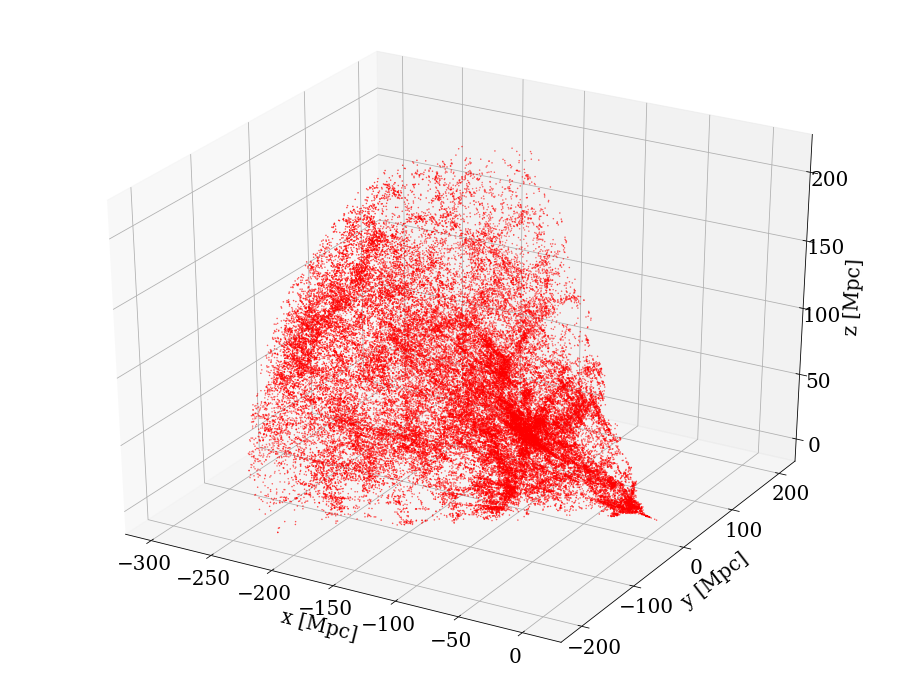

In [28]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z,c="r",marker=".",s=1)
ax.set_xlabel("x [Mpc]",labelpad=10,size=20)
ax.set_ylabel("y [Mpc]",labelpad=10,size=20)
ax.set_zlabel("z [Mpc]",labelpad=10,size=20)
plt.tight_layout()
plt.savefig("./Figures/cut_sdss.png")
plt.show()

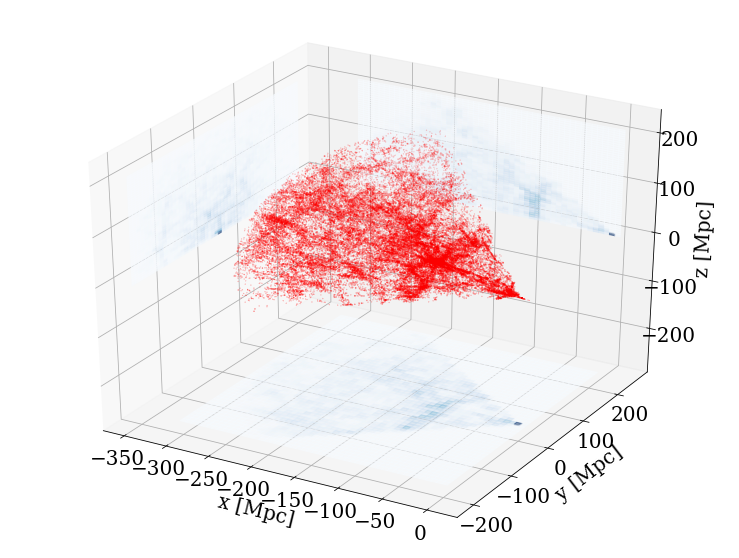

In [29]:
fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z, marker='.', c='r',s=0.1)
ax.set_xlabel("x [Mpc]",labelpad=10,size=20)
ax.set_ylabel("y [Mpc]",labelpad=10,size=20)
ax.set_zlabel("z [Mpc]",labelpad=10,size=20)

h, yedges, zedges = np.histogram2d(y, z, bins=50)
h = h.transpose()
normalized_map = plt.cm.Blues(h/h.max())
yy, zz = np.meshgrid(yedges, zedges)
xpos = min(x)-50 # Plane of histogram
xflat = np.full_like(yy, xpos)
p = ax.plot_surface(xflat, yy, zz, facecolors=normalized_map, rstride=1, cstride=1, shade=False,alpha=0.5)

h, xedges, zedges = np.histogram2d(x, z, bins=50)
h = h.transpose()
normalized_map = plt.cm.Blues(h/h.max())
xx, zz = np.meshgrid(xedges, zedges)
ypos = max(y)+50 # Plane of histogram
yflat = np.full_like(xx, ypos)
p = ax.plot_surface(xx,yflat, zz, facecolors=normalized_map, rstride=1, cstride=1, shade=False,alpha=0.5)

h, xedges, yedges = np.histogram2d(x,y, bins=50)
h = h.transpose()
normalized_map = plt.cm.Blues(h/h.max())
xx, yy = np.meshgrid(xedges, yedges)
zpos = min(y)-50 # Plane of histogram
zflat = np.full_like(xx, zpos)
p = ax.plot_surface(xx,yy, zflat, facecolors=normalized_map, rstride=1, cstride=1, shade=False,alpha=0.5)
plt.savefig("./Figures/cut_sdss.png")
plt.show()

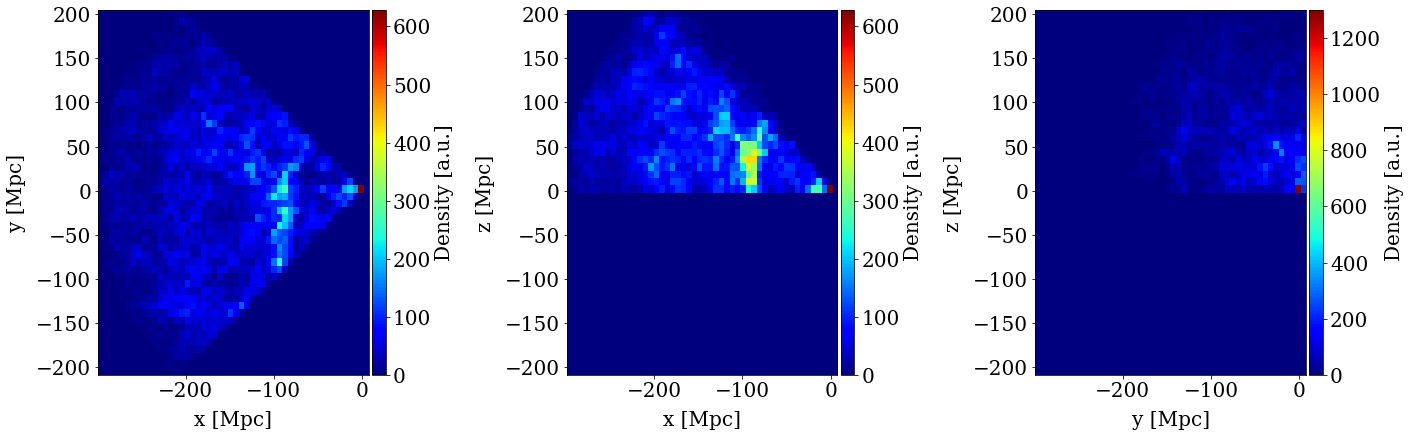

In [30]:
fig = plt.figure(figsize=(20, 20))
plt.jet()

H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
H = H.T  # Let each row list bins with common y range.
ax = fig.add_subplot(131)
plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.xlabel("x [Mpc]",labelpad=10,size=20)
plt.ylabel("y [Mpc]",labelpad=10,size=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=plt.colorbar(cax=cax)
cbar.ax.set_ylabel('Density [a.u.]', size=20)

H, xedges, yedges = np.histogram2d(x, z, bins=(xedges, yedges))
H = H.T  # Let each row list bins with common y range.
ax = fig.add_subplot(132)
plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.xlabel("x [Mpc]",labelpad=10,size=20)
plt.ylabel("z [Mpc]",labelpad=10,size=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=plt.colorbar(cax=cax)
cbar.ax.set_ylabel('Density [a.u.]', size=20)

H, xedges, yedges = np.histogram2d(y, z, bins=(xedges, yedges))
H = H.T  # Let each row list bins with common y range.
ax = fig.add_subplot(133)
plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.xlabel("y [Mpc]",labelpad=10,size=20)
plt.ylabel("z [Mpc]",labelpad=10,size=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=plt.colorbar(cax=cax)
cbar.ax.set_ylabel('Density [a.u.]', size=20)

fig.tight_layout()
plt.tight_layout()
plt.savefig("./Figures/cut_sdss2.png")
plt.show()

In [31]:
#Find halos with 0 connections
kkk=0
for i in range(0,len(con)):
    if len(con[i]) == 0:
        kkk=kkk+1
print(kkk)

588


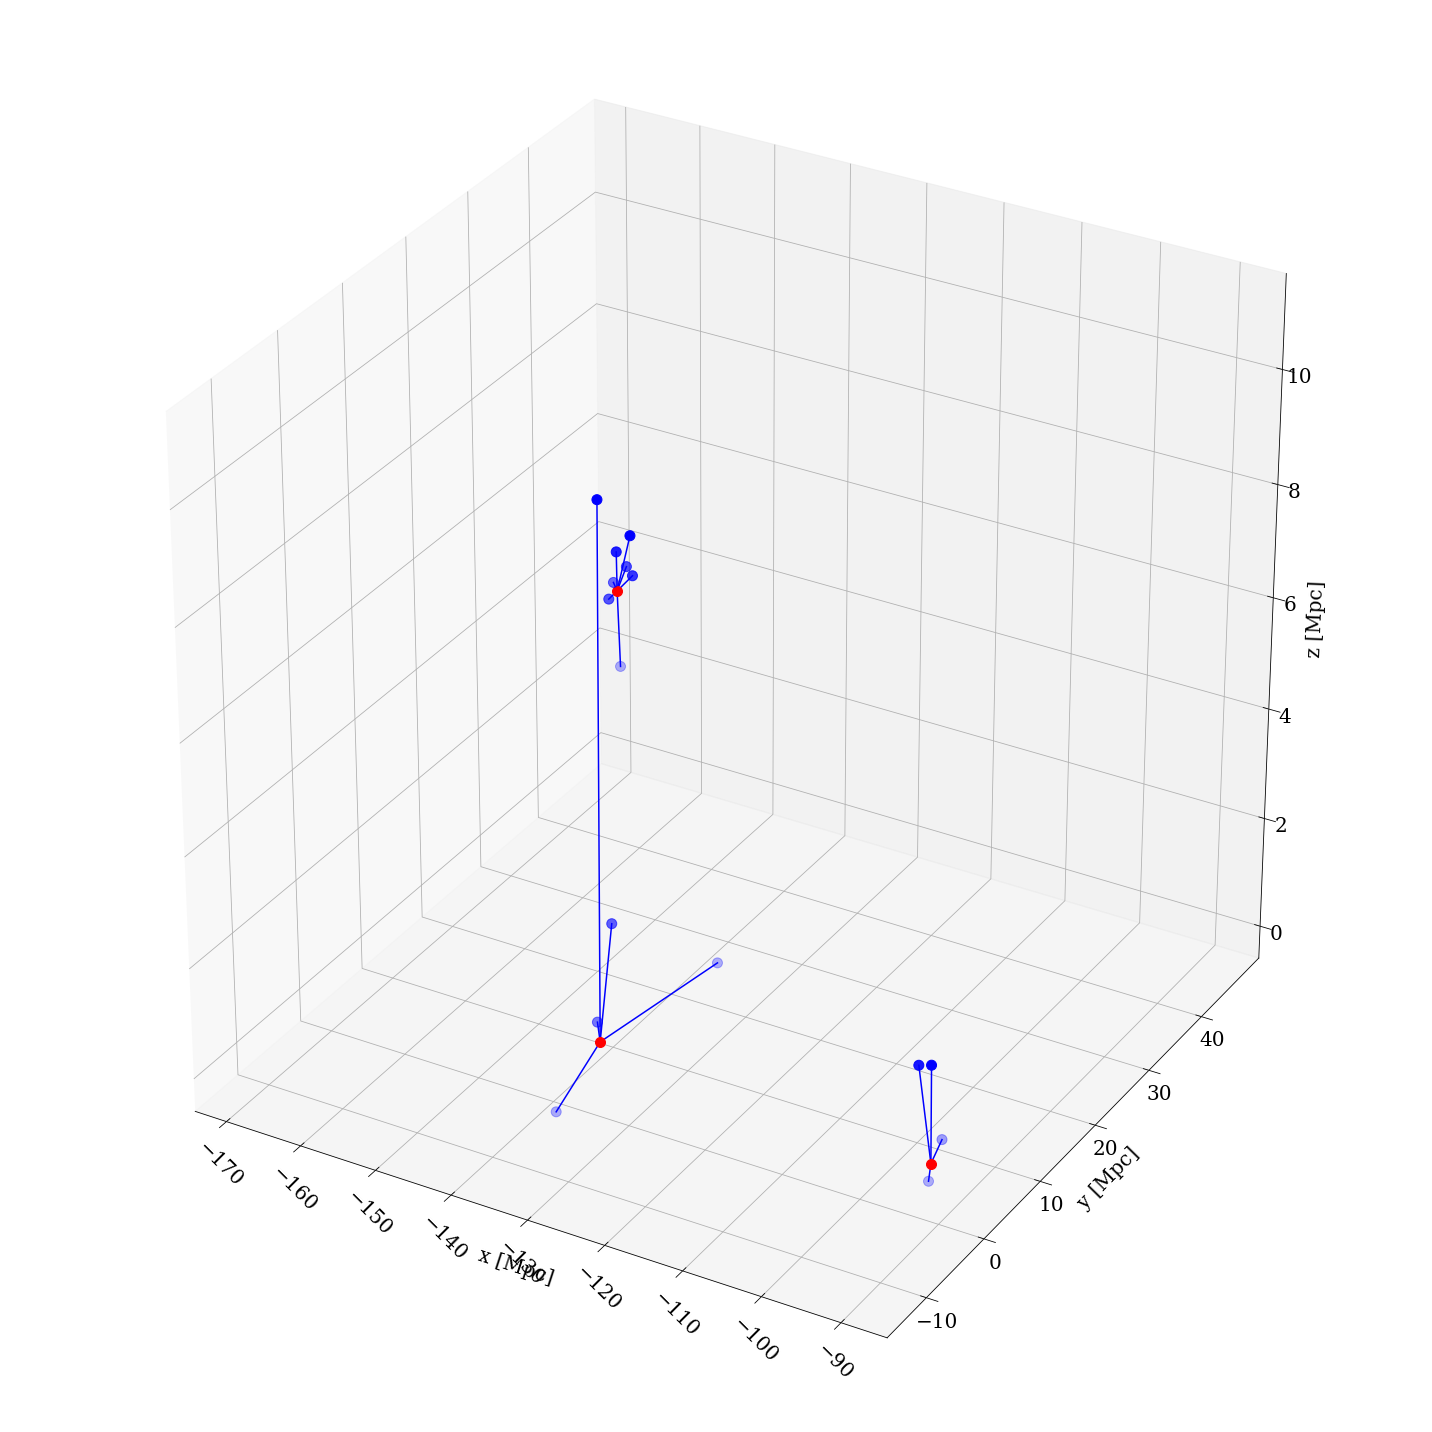

In [32]:
%matplotlib inline
jjj=ID[(ad>15)]
jjj=[1,200,33]
jjj=np.array(jjj).astype(int)

fig=plt.figure(figsize=(20,20))
ax.set_aspect('equal')
ax = fig.add_subplot(111, projection='3d')
# jjj=np.array([1])

for i in range(len(jjj)):
    nn=jjj[i]
    xn=[]
    yn=[]
    zn=[]
    xn.append(x[nn])
    yn.append(y[nn])
    zn.append(z[nn])
    for i in con[nn]:
        xn.append(x[i])
        yn.append(y[i])
        zn.append(z[i])
    xn=np.array(xn)
    yn=np.array(yn)
    zn=np.array(zn)

    #Plot a surface with volume=a*b*c
#     u = np.linspace(0, 2*np.pi, 100)
#     v = np.linspace(0, np.pi, 100)
#     rx=a[nn]
#     ry=b[nn]
#     rz=c[nn]
#     xs = rx * np.outer(np.cos(u), np.sin(v))+xn[0]
#     ys = ry * np.outer(np.sin(u), np.sin(v))+yn[0]
#     zs = rz * np.outer(np.ones(np.size(u)), np.cos(v))+zn[0]    
#     ax.plot_surface(xs, ys, zs, rstride=4, cstride=4, color='skyblue', edgecolors='k', lw=0.05, alpha=0.1)

    #Plot a surface with volume=ad**3
#     rx=ad[nn]
#     ry=ad[nn]
#     rz=ad[nn]
#     xs = rx * np.outer(np.cos(u), np.sin(v))+xn[0]
#     ys = ry * np.outer(np.sin(u), np.sin(v))+yn[0]
#     zs = rz * np.outer(np.ones(np.size(u)), np.cos(v))+zn[0]
#     ax.plot_surface(xs, ys, zs, rstride=4, cstride=4, color='skyblue', edgecolors='k', lw=0.05, alpha=0.1)    

    ax.scatter(xn[0],yn[0],zn[0],c="r",s=100)
    ax.scatter(xn[1:],yn[1:],zn[1:],c="b",s=100)
    ax.set_xlabel("x [Mpc]",labelpad=10,size=20)
    ax.set_ylabel("y [Mpc]",labelpad=10,size=20)
    ax.set_zlabel("z [Mpc]",labelpad=10,size=20)
    
    for i in range(1,len(xn)):
        ax.plot( [xn[0],xn[i]],[yn[0],yn[i]],[zn[0],zn[i]], c="blue" )

#     max_radius=max(np.column_stack((xn,yn,zn)).ravel())
#     for axis in 'xyz':
#         getattr(ax, 'set_{}lim'.format(axis))((-max_radius, max_radius))

    fig.tight_layout()
    plt.grid()
    plt.xticks(rotation=-45)
    plt.tight_layout()
plt.show()

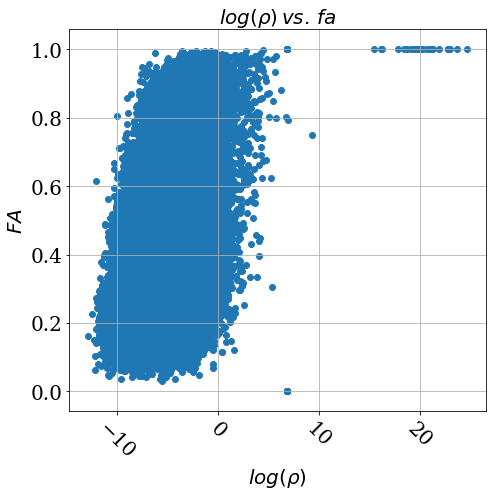

In [33]:
fig = plt.figure(figsize=(7,7))
plt.scatter(denlog,fa)
plt.title(r'$log(\rho)\,vs.\,fa$',size=20)
plt.xlabel(r'$log(\rho)$',size=20)
plt.ylabel(r'$FA$',size=20)
plt.grid()
plt.xticks(rotation=-45)
plt.tight_layout()
plt.savefig("./Figures/fa_logrho_sdss.png")
plt.show()

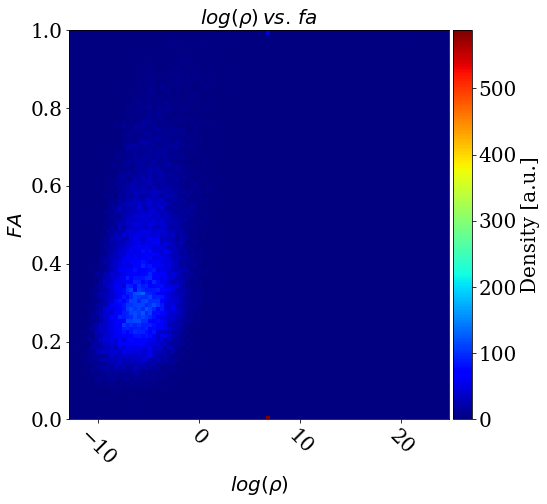

In [34]:
fig = plt.figure(figsize=(7,7))
plt.jet()
ax=plt.gca()
plt.title(r'$log(\rho)\,vs.\,fa$',size=20)
plt.xlabel(r'$log(\rho)$',size=20)
plt.ylabel(r'$FA$',size=20)
plt.xticks(rotation=-45)
plt.tight_layout()
plt.hist2d(denlog, fa, bins=100)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=plt.colorbar(cax=cax)
cbar.ax.set_ylabel('Density [a.u.]', size=20)
plt.savefig("./Figures/fa_logrho_sdss2.png")
plt.show()

In [35]:
# da0=ID[(denlog>10)]

# x10=x[da0]
# y10=y[da0]
# z10=z[da0]

# fig = plt.figure(figsize=(13,10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x10,y10,z10,c="r",marker=".",s=100)
# ax.set_xlabel("x [Mpc]",labelpad=10,size=20)
# ax.set_ylabel("y [Mpc]",labelpad=10,size=20)
# ax.set_zlabel("z [Mpc]",labelpad=10,size=20)
# plt.tight_layout()
# plt.savefig("./Figures/peaks_sdss.png")
# plt.show()

In [36]:
x_cut=-5
y_cut=0.5

void_mask = (denlog<x_cut) & (fa<y_cut)
voids=ID[void_mask]

peak_mask = (denlog>x_cut) & (fa<y_cut)
peaks=ID[peak_mask]

filament_mask = (denlog>x_cut) & (fa>y_cut)
filaments=ID[filament_mask]

sheet_mask = (denlog<x_cut) & (fa>y_cut)
sheets=ID[sheet_mask]

print(len(voids))
print(len(peaks))
print(len(filaments))
print(len(sheets))

27145
17775
7276
4799


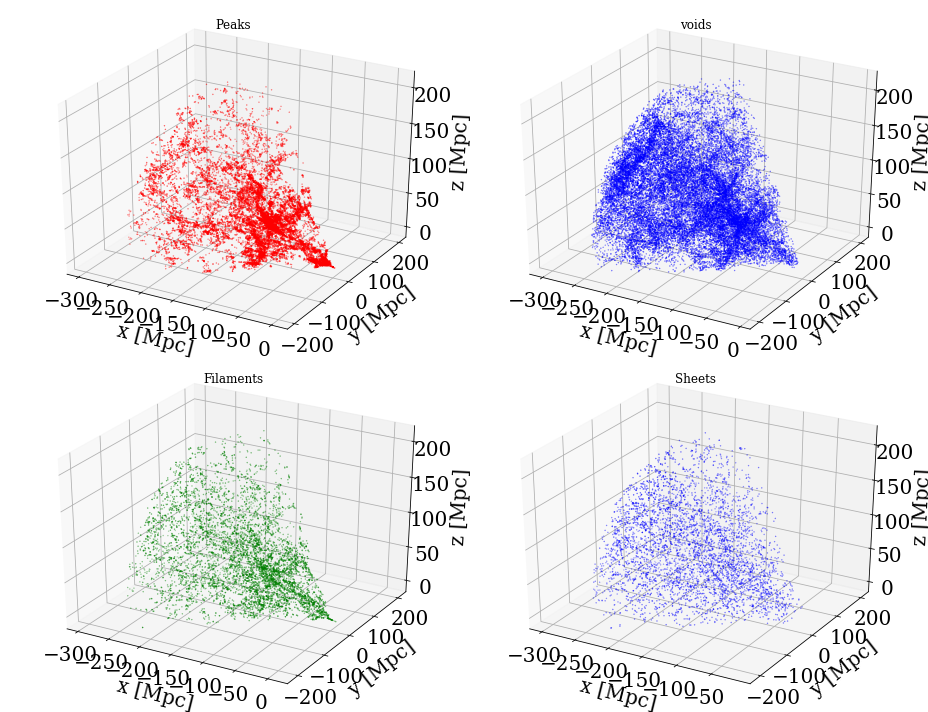

In [37]:
x_peaks=x[peaks]
y_peaks=y[peaks]
z_peaks=z[peaks]
x_voids=x[voids]
y_voids=y[voids]
z_voids=z[voids]
x_filaments=x[filaments]
y_filaments=y[filaments]
z_filaments=z[filaments]
x_sheets=x[sheets]
y_sheets=y[sheets]
z_sheets=z[sheets]

fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(221, projection='3d')
plt.title("Peaks")
ax.scatter(x_peaks,y_peaks,z_peaks,c="r",marker=".",s=0.5)
ax.set_xlabel("x [Mpc]",labelpad=10,size=20)
ax.set_ylabel("y [Mpc]",labelpad=10,size=20)
ax.set_zlabel("z [Mpc]",labelpad=10,size=20)
plt.tight_layout()

ax = fig.add_subplot(222, projection='3d')
plt.title("voids")
ax.scatter(x_voids,y_voids,z_voids,c="b",marker=".",s=0.5)
ax.set_xlabel("x [Mpc]",labelpad=10,size=20)
ax.set_ylabel("y [Mpc]",labelpad=10,size=20)
ax.set_zlabel("z [Mpc]",labelpad=10,size=20)
plt.tight_layout()

ax = fig.add_subplot(223, projection='3d')
plt.title("Filaments")
ax.scatter(x_filaments,y_filaments,z_filaments,c="g",marker=".",s=0.5)
ax.set_xlabel("x [Mpc]",labelpad=10,size=20)
ax.set_ylabel("y [Mpc]",labelpad=10,size=20)
ax.set_zlabel("z [Mpc]",labelpad=10,size=20)
plt.tight_layout()

ax = fig.add_subplot(224, projection='3d')
plt.title("Sheets")
ax.scatter(x_sheets,y_sheets,z_sheets,c="b",marker=".",s=0.5)
ax.set_xlabel("x [Mpc]",labelpad=10,size=20)
ax.set_ylabel("y [Mpc]",labelpad=10,size=20)
ax.set_zlabel("z [Mpc]",labelpad=10,size=20)
plt.tight_layout()

plt.savefig("./Figures/enviroment_sdss.png")
plt.show()

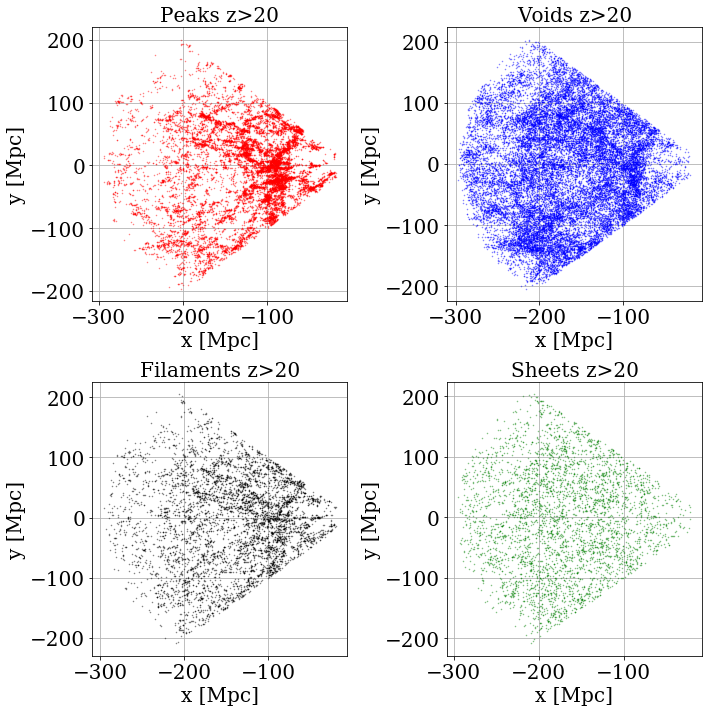

In [38]:
zlim=20
id_peak_zM20=ID[ (peak_mask) & (z>zlim) ]
id_void_zM20=ID[ (void_mask) & (z>zlim) ]
id_fil_zM20=ID[ (filament_mask) & (z>zlim) ]
id_sheet_zM20=ID[ (sheet_mask) & (z>zlim) ]

x_peak_zM20=x[id_peak_zM20]
y_peak_zM20=y[id_peak_zM20]

x_void_zM20=x[id_void_zM20]
y_void_zM20=y[id_void_zM20]

x_fil_zM20=x[id_fil_zM20]
y_fil_zM20=y[id_fil_zM20]

x_sheet_zM20=x[id_sheet_zM20]
y_sheet_zM20=y[id_sheet_zM20]

fig=plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title("Peaks z>"+str(zlim),size=20)
plt.plot(x_peak_zM20,y_peak_zM20,".",alpha=0.5, markersize=1,c="red")
plt.xlabel("x [Mpc]",size=20)
plt.ylabel("y [Mpc]",size=20)
plt.grid()

plt.subplot(222)
plt.title("Voids z>"+str(zlim),size=20)
plt.plot(x_void_zM20,y_void_zM20,".",alpha=0.5, markersize=1,c="blue")
plt.xlabel("x [Mpc]",size=20)
plt.ylabel("y [Mpc]",size=20)
plt.grid()

plt.subplot(223)
plt.title("Filaments z>"+str(zlim),size=20)
plt.plot(x_fil_zM20,y_fil_zM20,".",alpha=0.5, markersize=1,c="black")
plt.xlabel("x [Mpc]",size=20)
plt.ylabel("y [Mpc]",size=20)
plt.grid()

plt.subplot(224)
plt.title("Sheets z>"+str(zlim),size=20)
plt.plot(x_sheet_zM20,y_sheet_zM20,".",alpha=0.5, markersize=1,c="green")
plt.xlabel("x [Mpc]",size=20)
plt.ylabel("y [Mpc]",size=20)
plt.grid()

fig.tight_layout()

plt.savefig("./Figures/enviroment_cut_sdss.png")
plt.show()

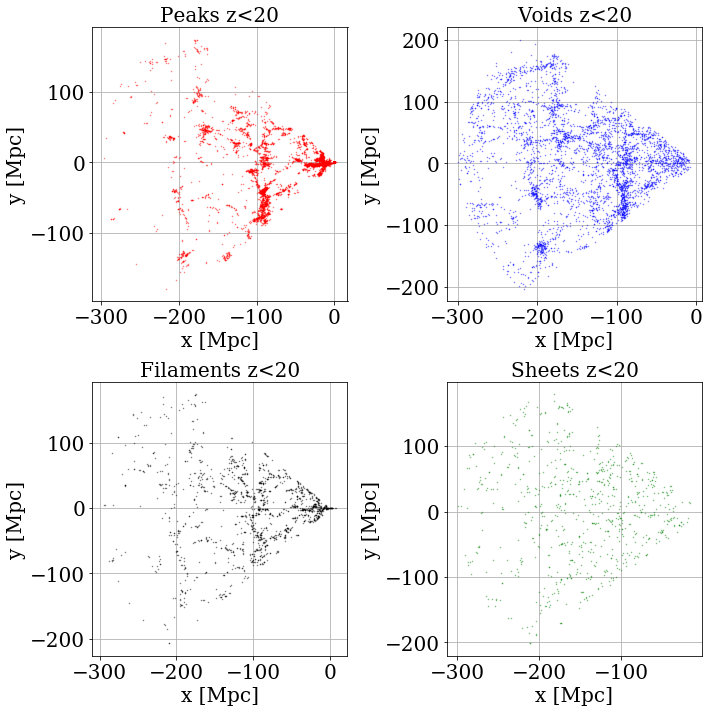

In [39]:
zlim=20
id_peak_zM20=ID[ (peak_mask) & (z<zlim) ]
id_void_zM20=ID[ (void_mask) & (z<zlim) ]
id_fil_zM20=ID[ (filament_mask) & (z<zlim) ]
id_sheet_zM20=ID[ (sheet_mask) & (z<zlim) ]

x_peak_zM20=x[id_peak_zM20]
y_peak_zM20=y[id_peak_zM20]

x_void_zM20=x[id_void_zM20]
y_void_zM20=y[id_void_zM20]

x_fil_zM20=x[id_fil_zM20]
y_fil_zM20=y[id_fil_zM20]

x_sheet_zM20=x[id_sheet_zM20]
y_sheet_zM20=y[id_sheet_zM20]

fig=plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title("Peaks z<"+str(zlim),size=20)
plt.plot(x_peak_zM20,y_peak_zM20,".",alpha=0.5, markersize=1,c="red")
plt.xlabel("x [Mpc]",size=20)
plt.ylabel("y [Mpc]",size=20)
plt.grid()

plt.subplot(222)
plt.title("Voids z<"+str(zlim),size=20)
plt.plot(x_void_zM20,y_void_zM20,".",alpha=0.5, markersize=1,c="blue")
plt.xlabel("x [Mpc]",size=20)
plt.ylabel("y [Mpc]",size=20)
plt.grid()

plt.subplot(223)
plt.title("Filaments z<"+str(zlim),size=20)
plt.plot(x_fil_zM20,y_fil_zM20,".",alpha=0.5, markersize=1,c="black")
plt.xlabel("x [Mpc]",size=20)
plt.ylabel("y [Mpc]",size=20)
plt.grid()

plt.subplot(224)
plt.title("Sheets z<"+str(zlim),size=20)
plt.plot(x_sheet_zM20,y_sheet_zM20,".",alpha=0.5, markersize=1,c="green")
plt.xlabel("x [Mpc]",size=20)
plt.ylabel("y [Mpc]",size=20)
plt.grid()

fig.tight_layout()

plt.savefig("./Figures/enviroment_cut_sdss_m20.png")
plt.show()

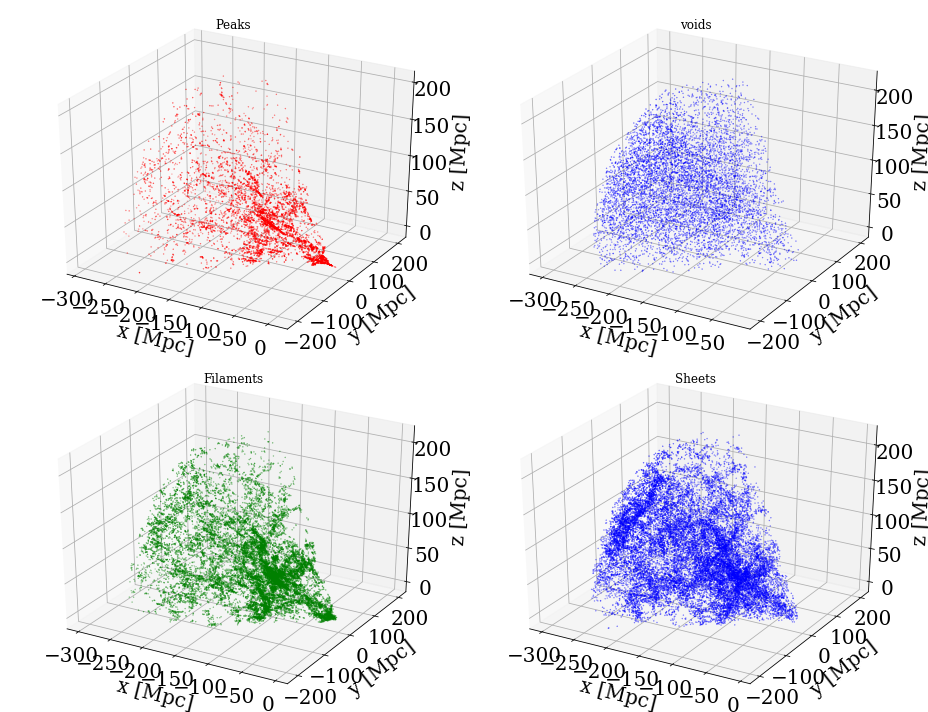

In [40]:
med_denlog=np.mean(denlog)

peak_ld= ( denlog > (med_denlog + sigma) )
filament_ld = ( denlog > med_denlog) & (denlog < (med_denlog+sigma) ) 
sheet_ld = ( denlog > (med_denlog-sigma)) & (denlog < med_denlog )
void_ld = ( denlog < (med_denlog-sigma ) )


x_peakld=x[peak_ld]
y_peakld=y[peak_ld]
z_peakld=z[peak_ld]

x_filld=x[filament_ld]
y_filld=y[filament_ld]
z_filld=z[filament_ld]

x_sheetld=x[sheet_ld]
y_sheetld=y[sheet_ld]
z_sheetld=z[sheet_ld]

x_voidld=x[void_ld]
y_voidld=y[void_ld]
z_voidld=z[void_ld]

fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(221, projection='3d')
plt.title("Peaks")
ax.scatter(x_peakld,y_peakld,z_peakld,c="r",marker=".",s=0.5)
ax.set_xlabel("x [Mpc]",labelpad=10,size=20)
ax.set_ylabel("y [Mpc]",labelpad=10,size=20)
ax.set_zlabel("z [Mpc]",labelpad=10,size=20)
plt.tight_layout()

ax = fig.add_subplot(222, projection='3d')
plt.title("voids")
ax.scatter(x_voidld,y_voidld,z_voidld,c="b",marker=".",s=0.5)
ax.set_xlabel("x [Mpc]",labelpad=10,size=20)
ax.set_ylabel("y [Mpc]",labelpad=10,size=20)
ax.set_zlabel("z [Mpc]",labelpad=10,size=20)
plt.tight_layout()

ax = fig.add_subplot(223, projection='3d')
plt.title("Filaments")
ax.scatter(x_filld,y_filld,z_filld,c="g",marker=".",s=0.5)
ax.set_xlabel("x [Mpc]",labelpad=10,size=20)
ax.set_ylabel("y [Mpc]",labelpad=10,size=20)
ax.set_zlabel("z [Mpc]",labelpad=10,size=20)
plt.tight_layout()

ax = fig.add_subplot(224, projection='3d')
plt.title("Sheets")
ax.scatter(x_sheetld,y_sheetld,z_sheetld,c="b",marker=".",s=0.5)
ax.set_xlabel("x [Mpc]",labelpad=10,size=20)
ax.set_ylabel("y [Mpc]",labelpad=10,size=20)
ax.set_zlabel("z [Mpc]",labelpad=10,size=20)
plt.tight_layout()

plt.savefig("./Figures/enviroment_sdss_ld.png")
plt.show()

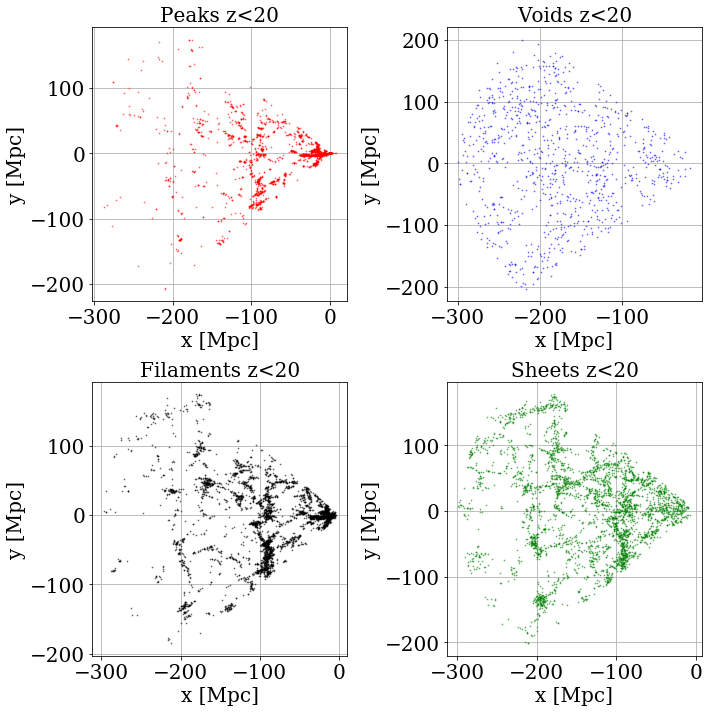

In [41]:
zlim=20
id_peak_zM20ld=ID[ (peak_ld) & (z<zlim) ]
id_void_zM20ld=ID[ (void_ld) & (z<zlim) ]
id_fil_zM20ld=ID[ (filament_ld) & (z<zlim) ]
id_sheet_zM20ld=ID[ (sheet_ld) & (z<zlim) ]

x_peak_zM20=x[id_peak_zM20ld]
y_peak_zM20=y[id_peak_zM20ld]

x_void_zM20=x[id_void_zM20ld]
y_void_zM20=y[id_void_zM20ld]

x_fil_zM20=x[id_fil_zM20ld]
y_fil_zM20=y[id_fil_zM20ld]

x_sheet_zM20=x[id_sheet_zM20ld]
y_sheet_zM20=y[id_sheet_zM20ld]

fig=plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title("Peaks z<"+str(zlim),size=20)
plt.plot(x_peak_zM20,y_peak_zM20,".",alpha=0.5, markersize=1.5,c="red")
plt.xlabel("x [Mpc]",size=20)
plt.ylabel("y [Mpc]",size=20)
plt.grid()

plt.subplot(222)
plt.title("Voids z<"+str(zlim),size=20)
plt.plot(x_void_zM20,y_void_zM20,".",alpha=0.5, markersize=1.5,c="blue")
plt.xlabel("x [Mpc]",size=20)
plt.ylabel("y [Mpc]",size=20)
plt.grid()

plt.subplot(223)
plt.title("Filaments z<"+str(zlim),size=20)
plt.plot(x_fil_zM20,y_fil_zM20,".",alpha=0.5, markersize=1.5,c="black")
plt.xlabel("x [Mpc]",size=20)
plt.ylabel("y [Mpc]",size=20)
plt.grid()

plt.subplot(224)
plt.title("Sheets z<"+str(zlim),size=20)
plt.plot(x_sheet_zM20,y_sheet_zM20,".",alpha=0.5, markersize=1.5,c="green")
plt.xlabel("x [Mpc]",size=20)
plt.ylabel("y [Mpc]",size=20)
plt.grid()

fig.tight_layout()

plt.savefig("./Figures/enviroment_cut_sdss_m20_ld.png")
plt.show()

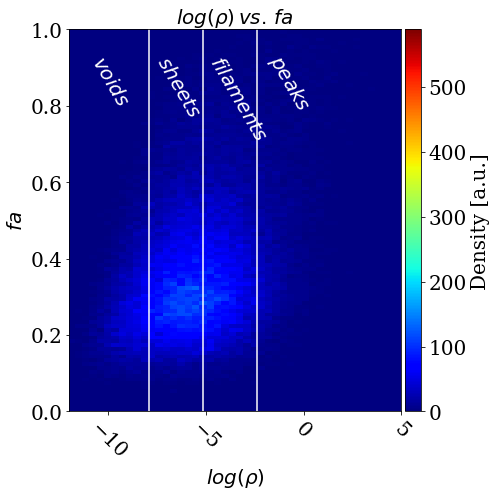

In [42]:

front1= med_denlog + sigma
front2 = med_denlog
front3 = med_denlog-sigma

fig = plt.figure(figsize=(7,7))
ax=plt.gca()
fal=np.linspace(0,1,100)
rhocut1=np.zeros(len(fal))+front1
rhocut2=np.zeros(len(fal))+front2
rhocut3=np.zeros(len(fal))+front3
rl=np.linspace(min(denlog),5,100)
facut=np.zeros(len(fal))+0.5
plt.title(r'$log(\rho)\,vs.\,fa$',size=20)
plt.plot(rhocut1,fal,c="white")
plt.plot(rhocut2,fal,c="white")
plt.plot(rhocut3,fal,c="white")
plt.xlabel(r'$log(\rho)$',size=20)
plt.ylabel(r'$fa$',size=20)
plt.xticks(rotation=-45)
plt.tight_layout()
plt.hist2d(denlog, fa, bins=100)
plt.xlim(-12,5)
plt.text(-11, 0.9 , r'$voids$', fontsize=20 , color="white", rotation=-60)
plt.text(-7.7, 0.9 , r'$sheets$', fontsize=20 , color="white", rotation=-60)
plt.text(-5, 0.9 , r'$filaments$', fontsize=20 , color="white", rotation=-60)
plt.text(-2, 0.9 , r'$peaks$', fontsize=20 , color="white", rotation=-60)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=plt.colorbar(cax=cax)
cbar.ax.set_ylabel('Density [a.u.]', size=20)
plt.tight_layout()
plt.savefig("./Figures/fa_logrho_sdss2_div.png")
plt.show()

In [43]:
def neigh_features(nc,ad,a,b,c,den,fa):
    nc_n=[]
    ad_n=[]
    a_n=[]
    b_n=[]
    c_n=[]
    den_n=[]
    fa_n=[] 
    for i in ID:
        nc_temp=0
        ad_temp=0
        a_temp=0
        b_temp=0
        c_temp=0
        den_temp=0
        fa_temp=0
        for j in con[i]:
            nc_temp=nc_temp+nc[j]
            ad_temp=ad_temp+ad[j]
            a_temp=a_temp+a[j]
            b_temp=b_temp+b[j]
            c_temp=c_temp+c[j]
            den_temp=den_temp+den[j]
            fa_temp=fa_temp+fa[j]
        if len(con[i])==0:
            nc_n.append(0)
            ad_n.append(0)
            a_n.append(0)
            b_n.append(0)
            c_n.append(0)
            den_n.append(0)
            fa_n.append(0)
        else:
            nc_n.append(nc_temp/len(con[i]))
            ad_n.append(ad_temp/len(con[i]))
            a_n.append(a_temp/len(con[i]))
            b_n.append(b_temp/len(con[i]))
            c_n.append(c_temp/len(con[i]))
            den_n.append(den_temp/len(con[i]))
            fa_n.append(fa_temp/len(con[i]))
    nc_n=np.array(nc_n)
    ad_n=np.array(ad_n)
    a_n=np.array(a_n)
    b_n=np.array(b_n)
    c_n=np.array(c_n)
    den_n=np.array(den_n)
    fa_n=np.array(fa_n)
    return nc_n,ad_n,a_n,b_n,c_n,den_n,fa_n

In [44]:
nc_n,ad_n,a_n,b_n,c_n,den_n,fa_n = neigh_features(nc,ad,a,b,c,den,fa)
Dnc=nc_n-nc
Dad=ad_n-ad
Da=a_n-a
Db=b_n-b
Dc=c_n-c
Dden=den_n-den
Dfa=fa_n-fa

In [45]:
f=h5py.File('Bsk_sdss_n.h5','w')
f.create_dataset('ID',data=ID)
f.create_dataset('coor',data=(x,y,z))
f.create_dataset('nc',data=nc)
f.create_dataset('av_d',data=ad)
f.create_dataset('abc',data=(a,b,c))
f.create_dataset('vol',data=vol)
f.create_dataset('den',data=den)
f.create_dataset('fa',data=fa)
f.create_dataset('env',data=env)
#Neightborhood
f.create_dataset('Dnc',data=Dnc)
f.create_dataset('Dad',data=Dad)
f.create_dataset('Dabc',data=(Da,Db,Dc))
f.create_dataset('Dden',data=Dden)
f.create_dataset('Dfa',data=Dfa)
f.close()